In [ ]:
import pandas as pd

In [ ]:
# Dataset da variavel target
df_aprovados = pd.read_csv('https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/dd201a034223a16732c6f639b40600b26bd3129c/dados/clientes_aprovados.csv')

# Dataset tratado no primeiro script
df_cadastrados = pd.read_csv('../../dados/credit_score/clientes_cadastrados_clean.csv')

In [ ]:
# ID Cliente -> Join com df_cadastrados
# Mes_referencia -> 0 = mês atual, -1 = mês passado, etc.
# Faixa_atraso -> quanto tempo atrasou o pagamento
df_aprovados.head()

In [ ]:
# Valores possíveis para Faixa_atraso
df_aprovados['Faixa_atraso'].value_counts()

In [ ]:
# Exemplo de linhas para um cliente específico
df_aprovados.loc[df_aprovados['ID_Cliente'] == 5001712]

**Variável target**: cliente é bom ou mau pagador?

Isso requere etapa de feature engineering, ponderar diversos fatores!

# Feature Engineering

## Mês de abertura e fechamento das contas

In [ ]:
df_goupby_id = df_aprovados.groupby('ID_Cliente').agg(Mes_inicio_conta=('Mes_referencia','min'), Mes_fim_conta = ('Mes_referencia','max')).reset_index()
df_goupby_id

In [ ]:
# Merge no df aprovados
df_aprovados_mes = df_aprovados.merge(df_goupby_id, on='ID_Cliente')
df_aprovados_mes

## Número de meses

In [ ]:
df_aprovados_mes['N_meses'] = df_aprovados_mes['Mes_fim_conta'] - df_aprovados_mes['Mes_inicio_conta']

In [ ]:
df_aprovados_mes

## MOB

Months on Book -> para cada mês de referência, indica há quantos meses o relacionamento com o cliente se iniciou

MOB = Mes_referencia - Mes_inicio_conta

In [ ]:
df_aprovados_mob = df_aprovados_mes.copy()

In [ ]:
df_aprovados_mob['MOB'] = df_aprovados_mob['Mes_referencia'] - df_aprovados_mob['Mes_inicio_conta']

In [ ]:
df_aprovados_mob

## Cliente ativo

In [ ]:
df_aprovados_mob['Cliente_ativo'] = df_aprovados_mob['Mes_fim_conta'].apply(lambda x: 1 if x == 0 else 0)

In [ ]:
df_aprovados_mob

## Faixa_atraso

Mudar Faixa_atraso para valores numéricos

In [ ]:
df_aprovados_faixa_atraso = df_aprovados_mob.copy()

In [ ]:
df_aprovados_faixa_atraso['Faixa_atraso'].unique()

In [ ]:
dict_faixa_atraso = {'nenhum empréstimo':0, 'pagamento realizado':1,'1-29 dias':2,
       '30-59 dias':3, '60-89 dias':4, '90-119 dias':5, '120-149 dias':6,
       '>150 dias':7}

In [ ]:
df_aprovados_faixa_atraso['Int_Faixa_atraso'] = df_aprovados_faixa_atraso['Faixa_atraso'].map(dict_faixa_atraso)
df_aprovados_faixa_atraso.drop(columns=['Faixa_atraso'], inplace=True)
df_aprovados_faixa_atraso.rename(columns={'Int_Faixa_atraso':'Faixa_atraso'}, inplace=True)

## Variável Bom/Mau pagador

In [ ]:
df_aprovados_pagadores = df_aprovados_faixa_atraso.copy()

In [ ]:
df_aprovados_pagadores['Mau_pagador'] = df_aprovados_pagadores['Faixa_atraso'].apply(lambda x: 1 if x > 2 else 0)

In [ ]:
df_aprovados_pagadores

## Número de vezes que foi mau pagador

In [ ]:
df_groupby_n_mau_pagador = df_aprovados_pagadores.groupby('ID_Cliente').agg(N_Mau_pagador = ('Mau_pagador','sum')).reset_index()
df_groupby_n_mau_pagador

In [ ]:
df_aprovados_pagadores = df_aprovados_pagadores.merge(df_groupby_n_mau_pagador, on='ID_Cliente')

In [ ]:
df_aprovados_pagadores

## Proporção de meses como mau pagador

In [ ]:
df_aprovados_pagadores['Ratio_Mau_pagador'] = df_aprovados_pagadores.apply(lambda x: (x['N_Mau_pagador'] / x['N_meses']) * 100 if x['N_meses'] > 0 else 0, axis=1)

In [ ]:
df_aprovados_pagadores['Ratio_Mau_pagador'].value_counts()

## Análise Vintage

### Qtd de clientes por Mes Inicio Conta

In [ ]:
# Criação de DF com ID_Clientes unicos, considerando apenas o mês mais atual de registro
df_clientes_drop_duplicates = df_aprovados_pagadores.drop_duplicates(subset='ID_Cliente', keep='first')
df_clientes_drop_duplicates.reset_index(drop=True, inplace=True)
df_clientes_drop_duplicates

In [ ]:
# Contagem de clientes únicos em cada valor de 
df_abertura = df_clientes_drop_duplicates.groupby('Mes_inicio_conta').agg({'ID_Cliente':'count'}).reset_index()
df_abertura.rename(columns={'ID_Cliente':'Qtd_Clientes'}, inplace=True)
df_abertura

In [ ]:
# Criação de DF Vintage: Agrupamento por Mes Inicio Conta e MOB (Months on Book)
df_vintage = df_aprovados_pagadores.groupby(['Mes_inicio_conta','MOB']).agg({'ID_Cliente':'count'}).reset_index()
df_vintage.rename(columns={'ID_Cliente':'Qtd_Clientes'}, inplace=True)
df_vintage

In [ ]:
## Isso não parece correto, vou desconsiderar!


# Merge df vintage e df abertura
df_vintage = df_vintage[['Mes_inicio_conta','MOB']].merge(df_abertura, on='Mes_inicio_conta', how='left')
df_vintage

### Proporção maus pagadores

In [ ]:
import numpy as np

df_vintage['Qtde_Mau_pagador'] = np.nan

In [ ]:
df_aprovados_pagadores.loc[(df_aprovados_pagadores['Mes_inicio_conta'] == -60) & (df_aprovados_pagadores['MOB'] == 60)]

In [ ]:
for j in sorted(df_vintage['Mes_inicio_conta'].unique()):
    ls = []

    for i in range(0, len(df_vintage['Mes_inicio_conta'].unique()) +1):
        due = list(df_aprovados_pagadores.query("Mau_pagador == 1 and MOB == @i and Mes_inicio_conta == @j")['ID_Cliente'])

        n_mau_pagadores = len(due)

        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Mes_inicio_conta'] == j), 'Qtde_Mau_pagador'] = n_mau_pagadores


df_vintage['Taxa_Mau_pagador'] = df_vintage['Qtde_Mau_pagador'] / df_vintage['Qtd_Clientes'] * 100

### Tabela Pivot

In [ ]:
df_vintage

In [ ]:
df_vintage_pivot = df_vintage.pivot(index='Mes_inicio_conta', columns='MOB', values='Taxa_Mau_pagador')
df_vintage_pivot

In [ ]:
import seaborn as sns

In [ ]:
df_vintage_pivot

In [ ]:
df_vintage_pivot.T.iloc[:, :10]

In [ ]:
sns.lineplot(df_vintage_pivot.T.iloc[:, :10].fillna(0))

Percebe-se que existem mais clientes pagadores nos menores valores de MOB, ou seja, logo após abertura da conta há uma tendência dos clientes atrasarem o pagamento de dívidas.

Por outro lado, clientes com contas há mais tempo (maior MOB), geralmente são melhores pagadores.

In [ ]:
# Análise: acumulado de clientes por N_meses (janela)
sns.histplot(df_clientes_drop_duplicates, x='N_meses', cumulative=True, kde=True)

# Criação de variáveis binárias por faixa de atraso

In [ ]:
dict_intervalo_atraso = {'60_dias':3,'90_dias':4,'120_dias':5,'150_dias':6, 'maior_150_dias':7}

In [ ]:
for key,value in dict_intervalo_atraso.items():
    df_aprovados_pagadores[f'Mau_{key}'] = df_aprovados_pagadores.apply(lambda x: 1 if x['Faixa_atraso'] >= value else 0, axis=1)

In [ ]:
df_aprovados_pagadores.query('Mau_90_dias == 1')

## Análise: taxa de clientes mau pagadores por faixa de atraso

In [75]:
dict_taxa_mau = {}
id_sum = df_aprovados_pagadores['ID_Cliente'].nunique()

for key in dict_intervalo_atraso.keys():
    df_min_mau = df_aprovados_pagadores.query(f'Mau_{key} == 1').groupby('ID_Cliente').agg({'MOB':'min'}).reset_index()

    df_mob_taxa_mau = pd.DataFrame(columns=['MOB', 'Taxa_mau'])

    lst = []

    for i in range(0, df_aprovados_pagadores['MOB'].nunique()):
        due = df_min_mau.query('MOB == @i')['ID_Cliente'].to_list()
        lst.extend(due)

        df_mob_taxa_mau = pd.concat([df_mob_taxa_mau, pd.DataFrame(data={'MOB': [i], 'Taxa_mau': [len(set(lst))/id_sum]})])

    dict_taxa_mau[key] = df_mob_taxa_mau['Taxa_mau']

df_taxa_mau = pd.DataFrame(dict_taxa_mau)
df_taxa_mau.reset_index(drop=True, inplace=True)

In [76]:
display(df_taxa_mau.head())

,60_dias,90_dias,120_dias,150_dias,maior_150_dias
0,0.000304,0.000022,0.000022,0.000022,0.000022
1,0.011612,0.000174,0.000087,0.000087,0.000087
2,0.025878,0.001153,0.000196,0.000174,0.000174
3,0.036860,0.002240,0.000696,0.000304,0.000304
4,0.047385,0.003392,0.001044,0.000696,0.000348


In [72]:
import matplotlib.pyplot as plt

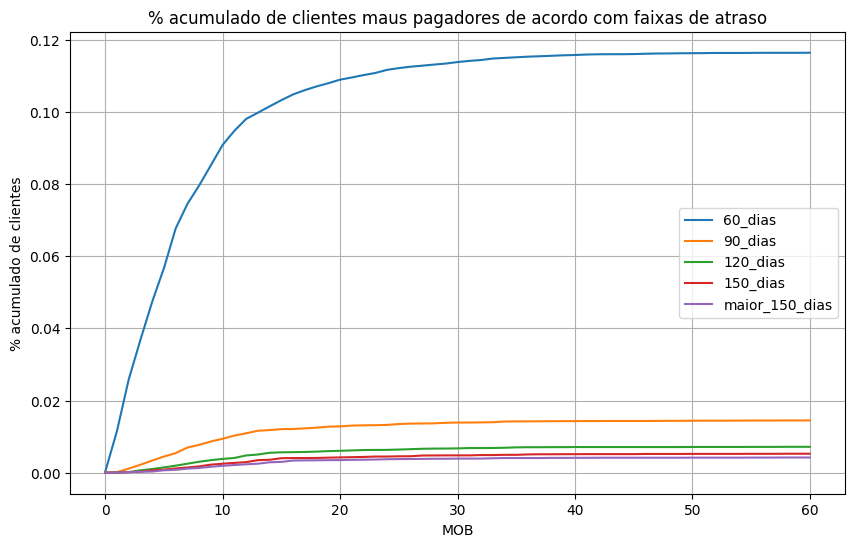

In [77]:
df_taxa_mau.plot(grid = True, title = '% acumulado de clientes maus pagadores de acordo com faixas de atraso', figsize=(10, 6))
plt.xlabel('MOB')
plt.ylabel('% acumulado de clientes')
plt.show()

Aparentemente a curva de atraso entre 30 e 60 dias é muito diferente das outras. Em geral, é muito mais comum que pessoas atrasem pagamentos por esse período de tempo.

Por isso, talvez seja uma boa ideia desconsiderar clientes que atrasaram nesta faixa entre 30 e 60 dias.

Outro ponto a se considerar é o número de meses que um cliente está cadastrado. Por exemplo, é possível dizer que uma pessoa é mau pagadora com base em um histórico de apenas 6 meses?

# Filtragem Dataframe

## Filtro de clientes com mais de 6 meses de histórico na base

In [91]:
df_aprovados_pagadores_filtered = df_aprovados_pagadores.query('N_meses > 6')
df_aprovados_pagadores_filtered.reset_index(drop=True, inplace=True)

In [92]:
df_aprovados_pagadores_filtered

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador,Mau_60_dias,Mau_90_dias,Mau_120_dias,Mau_150_dias,Mau_maior_150_dias
0,5001712,0,-18,0,18,18,1,1,0,0,0.0,0,0,0,0,0
1,5001712,-1,-18,0,18,17,1,1,0,0,0.0,0,0,0,0,0
2,5001712,-2,-18,0,18,16,1,1,0,0,0.0,0,0,0,0,0
3,5001712,-3,-18,0,18,15,1,1,0,0,0.0,0,0,0,0,0
4,5001712,-4,-18,0,18,14,1,1,0,0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012182,5150487,-25,-29,0,29,4,1,1,0,0,0.0,0,0,0,0,0
1012183,5150487,-26,-29,0,29,3,1,1,0,0,0.0,0,0,0,0,0
1012184,5150487,-27,-29,0,29,2,1,1,0,0,0.0,0,0,0,0,0
1012185,5150487,-28,-29,0,29,1,1,1,0,0,0.0,0,0,0,0,0


In [83]:
df_aprovados_pagadores_filtered.query('Faixa_atraso in [2,3,4]')

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador,Mau_60_dias,Mau_90_dias,Mau_120_dias,Mau_150_dias,Mau_maior_150_dias
9,5001712,-9,-18,0,18,9,1,2,0,0,0.0,0,0,0,0,0
10,5001712,-10,-18,0,18,8,1,2,0,0,0.0,0,0,0,0,0
11,5001712,-11,-18,0,18,7,1,2,0,0,0.0,0,0,0,0,0
12,5001712,-12,-18,0,18,6,1,2,0,0,0.0,0,0,0,0,0
13,5001712,-13,-18,0,18,5,1,2,0,0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012152,5150484,-8,-12,0,12,4,1,2,0,0,0.0,0,0,0,0,0
1012153,5150484,-9,-12,0,12,3,1,2,0,0,0.0,0,0,0,0,0
1012154,5150484,-10,-12,0,12,2,1,2,0,0,0.0,0,0,0,0,0
1012155,5150484,-11,-12,0,12,1,1,2,0,0,0.0,0,0,0,0,0


In [ ]:
def verifica(registros):
  lista_status = registros['Faixa_atraso'].to_list()
  if '60-89 dias' in lista_status or '90-119 dias' in lista_status or '120-149 dias' in lista_status or '>150 dias' in lista_status:
    return 1
  else:
    return 0